<a href="https://githubtocolab.com/ml-for-high-risk-apps-book/Machine-Learning-for-High-Risk-Applications-Book/blob/main/code/Chapter-7/2.Transfer%20learning-Stage_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 7: Explaining a PyTorch Image Classifier

## <font color=green>**Transfer Learning Stage 1**</font>

In this notebook we'll train an image classifier using transfer learning. Training a CNN from scratch is very expensive, both in terms of data as well as computation time. As such, a prevalent technique is to use models that have been previously trained on a large scale image dataset (such as
ImageNet) and then reuse them as a starting point for another task.
We’ll use a DenseNet-121 architecture trained on ImageNet dataset. 

The performance of the model is then evaluated on a held-out dataset.

## Setting the environment

If you are using Colab, it comes preinstalled with PyTorch and other commonly used libraries for machine and Deep learning. If you are executing this notebook in your local system, you will need to install them manually via the following commands:

In [ ]:
#!pip3 install torch torchvision numpy pandas matplotlib seaborn scikit-learn --quiet

In [5]:
#Importing the necessary libraries

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import random


import copy
import os
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, classification_report


import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid, save_image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from PIL import Image

from sklearn.metrics import confusion_matrix

# Seed
seed = 123
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
random_seed = 12345

In [6]:
# Defining seed_worker function for reproducible experiments
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

## Loading the processed dataset

Load the preprocessed training mentioned in the [`Data Preparation`](https://github.com/ml-for-high-risk-apps-book/Machine-Learning-for-High-Risk-Applications-Book/blob/main/code/Chapter-7/0.Data%20Preparation.ipynb) notebook. 
*Alternatively you can upload the preprocessed dataset from [here](https://drive.google.com/file/d/1I6j55Id6V0EBOSKsXziahaO5BFjSD6hH/view?usp=sharing)*

In [7]:
train_dataset = torch.load('train_dataset.pt')

In [8]:
PATH_preprocessed_dataset = 'chest_xray_preprocessed' 

We have already augmented and normalized the training dataset in the Data Preparation notebook. We'll now just perform normalization for validation set.

In [9]:
train_ds = train_dataset 
val_ds = ImageFolder(PATH_preprocessed_dataset+'/val', 
                        transform = transforms.Compose([transforms.Resize((224,224)),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                           ]))

len(train_ds), len(val_ds)


(7269, 975)

## Creating Training & Validation Dataloaders

In [7]:
batch_size=32

train_dl = DataLoader(train_ds, batch_size, shuffle=True, worker_init_fn=seed_worker)
val_dl = DataLoader(val_ds, batch_size, worker_init_fn=seed_worker)
loaders = {'train':train_dl, 'val':val_dl}
dataset_sizes = {'train':len(train_ds), 'val':len(val_ds)}

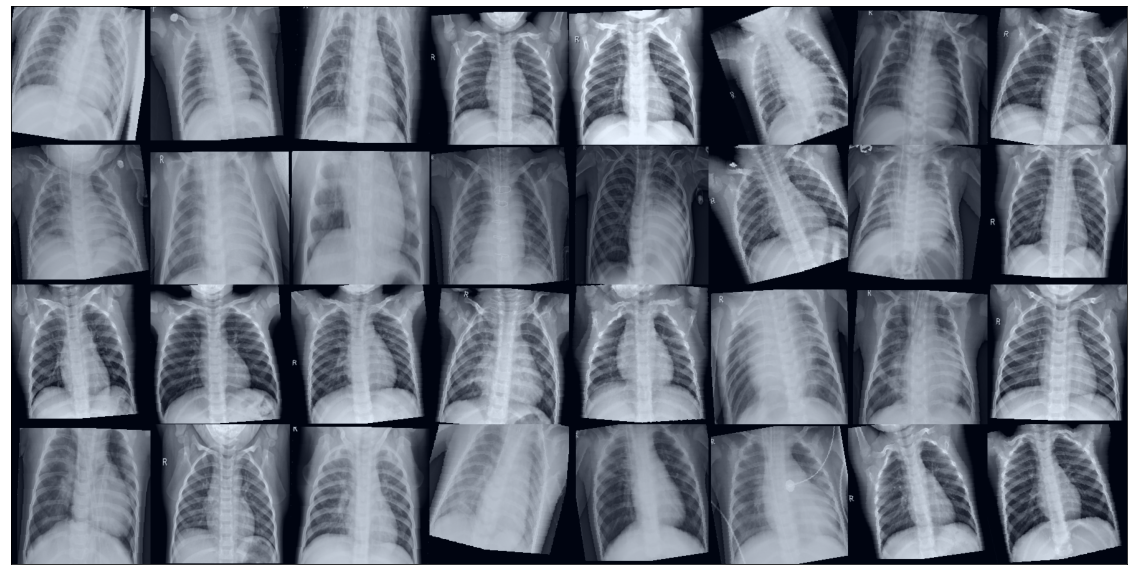

In [8]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(20, 14))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:60], nrow=8, padding=0,normalize=True).permute(1, 2, 0))
        break
        
show_batch(train_dl)

## Model Training
It is advisable to use a GPU  to speed up the training. 

In [10]:
classes = ['Normal', 'Pneumonia']
model = torchvision.models.densenet121(pretrained=True)

/opt/homebrew/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /Users/parulpandey/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

In [10]:
# Unfreeze training for all "features" layers
for param in model.parameters():
    param.requires_grad = True
# New layers automatically have requires_grad = True
in_features = model.classifier.in_features
model.classifier = nn.Linear(in_features, len(classes)

In [11]:
# Specifying the criterion, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

#Decaying Learing Rate by a factor of 0.1 every 4 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 4, gamma=0.1)

In [12]:
# Defining the generic training function
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}


def train(model, criterion, optimizer, scheduler, epochs):
  since = time.time()
  best_model = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  for epoch in range(epochs):
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_corrects = 0.0

      for inputs, labels in loaders[phase]:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase=='train'):
          outp = model(inputs)
          _, pred = torch.max(outp, 1)
          loss = criterion(outp, labels)
        
          if phase == 'train':
            loss.backward()
            optimizer.step()
        
        running_loss += loss.item()*inputs.size(0)
        running_corrects += torch.sum(pred == labels.data)


      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double()/dataset_sizes[phase]
      losses[phase].append(epoch_loss)
      accuracies[phase].append(epoch_acc)
      if phase == 'train':
        print('Epoch: {}/{}'.format(epoch+1, epochs))
      print('{} - loss:{}, accuracy{}'.format(phase, epoch_loss, epoch_acc))
    
            
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model = copy.deepcopy(model.state_dict())
    scheduler.step()  
  print('Best accuracy {}'.format(best_acc))

  # load best model weights
  model.load_state_dict(best_model)
  return model   

In [13]:
model.to(device)
epochs = 15
model = train(model, criterion, optimizer, scheduler, epochs)

/home/paperspace/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 1/15
train - loss:0.11781827048390194, accuracy0.9587073608617595
val - loss:0.10020992374133429, accuracy0.9631525076765609
Epoch: 2/15
train - loss:0.07049086239628655, accuracy0.9745287253141831
val - loss:0.07153199927189302, accuracy0.9754350051177073
Epoch: 3/15
train - loss:0.060130567898509, accuracy0.979129263913824
val - loss:0.033600609736210124, accuracy0.9887410440122825
Epoch: 4/15
train - loss:0.05151663233084634, accuracy0.9820466786355476
val - loss:0.028980707339828066, accuracy0.9907881269191402
Epoch: 5/15
train - loss:0.024223130292683852, accuracy0.9913599640933574
val - loss:0.016762229338233018, accuracy0.9938587512794268
Epoch: 6/15
train - loss:0.017876714157892385, accuracy0.9940529622980252
val - loss:0.009135399204764626, accuracy0.9989764585465711
Epoch: 7/15
train - loss:0.012401141601506389, accuracy0.9957360861759426
val - loss:0.008737178552850982, accuracy0.9979529170931423
Epoch: 8/15
train - loss:0.012026740670186607, accuracy0.99607271095152

## Model Evaluation on Validation Set

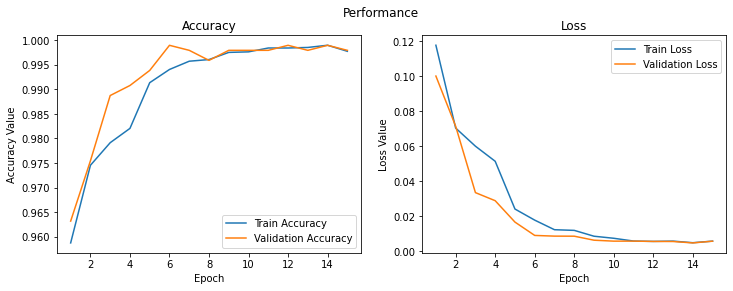

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Performance', fontsize=12)


epoch_list = list(range(1,epochs+1))
ax1.plot(epoch_list, torch.tensor(accuracies['train'], device = 'cpu'), label='Train Accuracy')
ax1.plot(epoch_list, torch.tensor(accuracies['val'], device = 'cpu'), label='Validation Accuracy')
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, losses['train'], label='Train Loss')
ax2.plot(epoch_list, losses['val'], label='Validation Loss')
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

## Model Evaluation on Test Set

In [15]:
testset = ImageFolder(PATH_augmented+'/test', 
                           transform=torchvision.transforms.Compose([torchvision.transforms.Resize((224,224)), 
                                                 torchvision.transforms.ToTensor(),
                                                 torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),                                                               
                                                 
                                                ]))

In [16]:
test_dl = DataLoader(testset, batch_size=256)
model.to(device);


In [17]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1) 
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)), preds

In [18]:
def validation(batch):
        images,labels = batch
        images,labels = images.to(device),labels.to(device)
        output = model(images)                                      
        loss = F.cross_entropy(output, labels)                    
        acc,predictions = accuracy(output, labels)                       
        
        return {'valid_loss': loss.detach(), 'valid_accuracy':acc.detach(), 'predictions':predictions.detach(), 'labels':labels.detach()}

In [19]:
@torch.no_grad()
def test_predict(model, test_dataloader):
    model.eval()
    
    outputs = [validation(batch) for batch in test_dataloader] 
    batch_losses = [x['valid_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()           
    batch_accs = [x['valid_accuracy'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()             
  
    batch_preds = [pred for x in outputs for pred in x['predictions'].tolist()] 
    batch_labels = [label for x in outputs for label in x['labels'].tolist()]  
    
    print('test_loss: {:.4f}, test_acc: {:.4f}'
          .format(epoch_loss.item(), epoch_acc.item()))
    
    return batch_preds, batch_labels

In [20]:
preds,labels = test_predict(model, test_dl)

test_loss: 0.4695, test_acc: 0.9036


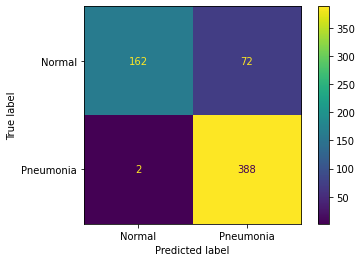

In [21]:
cm  = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Pneumonia'])
disp.plot();

In [23]:

print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       0.99      0.69      0.81       234
           1       0.84      0.99      0.91       390

    accuracy                           0.88       624
   macro avg       0.92      0.84      0.86       624
weighted avg       0.90      0.88      0.88       624



In [24]:
torch.save(model, 'Finetune1_best_model.pt') The saved model can be accessed from [here]()
